# Clasificador de imágenes de skins de Counter-Strike: Global Offensive

In [3]:
# descargamos el dataset
# 2786 imagenes de 300x300 etiquetadas, 58 categorias

# Esto sobrescribirá la carpeta dataset, comentar si ya la descargó.
!gdown 1Hqe8nS2gGVTZELCC5eW-hsHOyWtFULD0
!unzip -o dataset.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Hqe8nS2gGVTZELCC5eW-hsHOyWtFULD0
From (redirected): https://drive.google.com/uc?id=1Hqe8nS2gGVTZELCC5eW-hsHOyWtFULD0&confirm=t&uuid=4e286f0b-f5f0-4bb0-8d0d-32dca998ec68
To: /home/matias/projects/csgo-skin-identifier/dataset.zip
100%|████████████████████████████████████████| 100M/100M [00:01<00:00, 62.6MB/s]
Archive:  dataset.zip
  inflating: dataset/labels.csv      
  inflating: dataset/images/2.jpg    
  inflating: dataset/images/3.jpg    
  inflating: dataset/images/5.jpg    
  inflating: dataset/images/7.jpg    
  inflating: dataset/images/15.jpg   
  inflating: dataset/images/18.jpg   
  inflating: dataset/images/20.jpg   
  inflating: dataset/images/21.jpg   
  inflating: dataset/images/22.jpg   
  inflating: dataset/images/25.jpg   
  inflating: dataset/images/26.jpg   
  inflating: dataset/images/28.jpg   
  inflating: dataset/images/32.jpg   
  inflating: dataset/images/35.jpg   
  inflating: dataset/images/41.jpg 

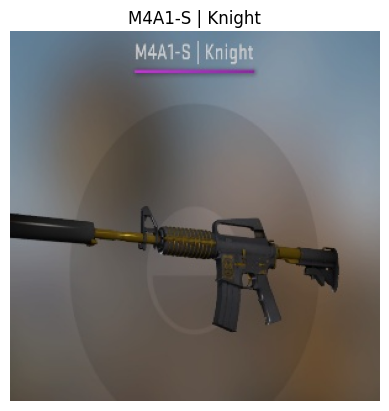

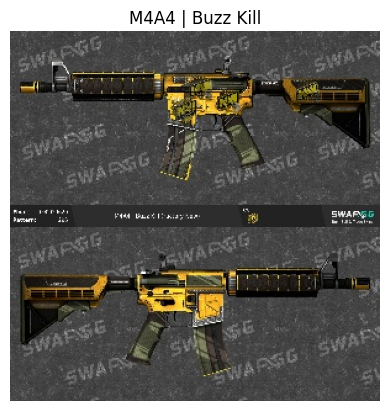

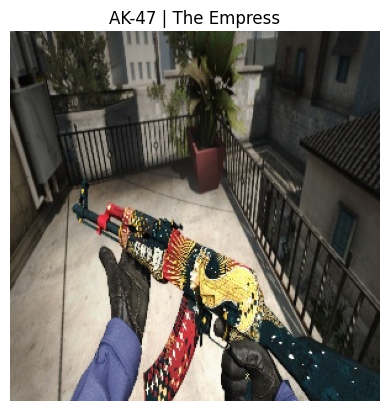

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def show_img(img_path, label):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

label_dir = os.path.join(os.getcwd(), "dataset", "labels.csv")
dataset_dir = os.path.join(os.getcwd(), "dataset", "images")

LABELS = ["" for _ in range(len(os.listdir(dataset_dir)))]
with open(label_dir) as f:
    f.readline()
    for line in f.readlines():
        img_name, label = line.strip().split(",")
        img_id  = img_name.split(".")[0]
        LABELS[int(img_id)] = label


# Más adelante nos servirá convertir los labels a números
unique_labels = set(LABELS)
label2num = {label: i for i, label in enumerate(unique_labels)}
num2label = {i: label for i, label in enumerate(unique_labels)}

# visualizamos algunas imagenes del dataset
for img_id in random.sample(range(len(LABELS)), 3):
    img_path = os.path.join(dataset_dir, f"{img_id}.jpg")
    show_img(img_path, LABELS[img_id])



## Extracción de deep features con modelo preentrenado ResNet y clasificación con K-NN
Calcularemos deep features para cada imagen del dataset con el modelo preentrenado ResNet, luego usaremos estos descriptores para entrenar un clasificador K-NN.

In [5]:
from sklearn.model_selection import train_test_split

# Separamos el dataset en train y test
all_images = os.listdir(dataset_dir)
labels_dict = {i: label for i, label in enumerate(LABELS)}

train_test_split = train_test_split(all_images, test_size=0.2, random_state=1)
train_images, test_images = train_test_split
train_labels = [labels_dict[int(img_id.split(".")[0])] for img_id in train_images]
test_labels = [labels_dict[int(img_id.split(".")[0])] for img_id in test_images]

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo preentrenado ResNet
model = resnet50(pretrained=True)
model.to(device)
model.eval()  # Setearlo en modo evaluacion, para que no se actualicen los pesos

# Convertimos al input esperado por el modelo
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image).unsqueeze(0).to(device)  # Add a batch dimension and move the image to the device
    features = model(image)  # Pass the image through the model to get the deep features
    return features.detach().cpu().numpy().flatten()  # Convert the features to a numpy array

# Calculamos las deep features del set de train
features = []
for img_id in train_images:
    img_path = os.path.join(dataset_dir, img_id)
    features.append(extract_features(img_path))

/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ahora que ya tenemos descriptores para cada imagen del conjunto de entrenamiento, podemos usar estos descriptores para entrenar un clasificador KNN.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


train_labels_num = np.array([label2num[label] for label in train_labels])

knn_classifier = KNeighborsClassifier(n_neighbors=11)
knn_classifier.fit(np.array(features), train_labels_num)


KNeighborsClassifier(n_neighbors=11)

In [8]:
# Calculamos las deep features del set de test
test_features = []
for img_id in test_images:
    img_path = os.path.join(dataset_dir, img_id)
    test_features.append(extract_features(img_path))


In [9]:
test_labels_num = np.array([label2num[label] for label in test_labels])
# Predecimos las labels del set de test
pred_labels_num = knn_classifier.predict(np.array(test_features))

In [10]:
# Calculamos el accuracy
acc = np.sum(pred_labels_num == test_labels_num) / len(test_labels_num)
print(f"Accuracy: {acc}")

Accuracy: 0.4050179211469534


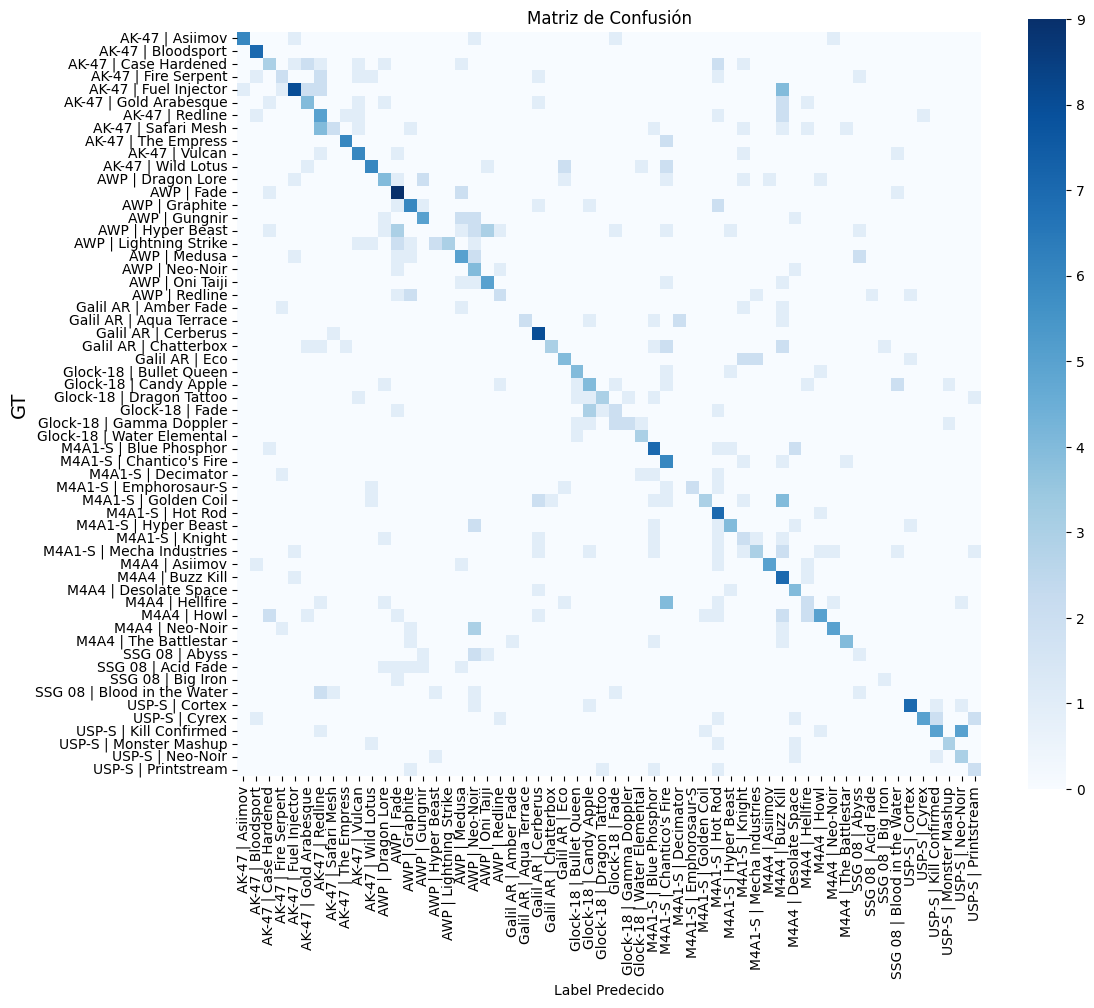

In [11]:
# Matriz de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(gt, pred, labels):
    conf_matrix = confusion_matrix(gt, pred, labels=labels)
    plt.figure(figsize=(12,10))
    sns.heatmap(conf_matrix, cmap="Blues", xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 18}, square=True)
    plt.xlabel("Label Predecido")
    plt.ylabel("GT", fontsize=14)
    plt.title("Matriz de Confusión")
    plt.xticks()
    plt.yticks()
    plt.savefig("confusion_matrix_tl.png")
    plt.show()
    

pred_skins = [num2label[l] for l in pred_labels_num]
real_skins = [num2label[l] for l in test_labels_num]
sorted_categories = sorted(unique_labels)
plot_confusion_matrix(real_skins, pred_skins, sorted_categories)

Al observar la matriz de confusión, notamos que el modelo confunde categorías correspondientes a la misma arma, pero distinta skin. Por ejemplo, el modelo confunde imágenes del arma "USP-S" que tienen la skin "Kill Confirmed" con otras USP-S, pero de skin "Cortex", "Cyrex". 

A continuación calculamos otras estadísticas para evaluar el modelo: presición, recall y F1-score.

In [12]:
from sklearn.metrics import classification_report
print(classification_report(real_skins, pred_skins, target_names=sorted_categories))

                             precision    recall  f1-score   support

            AK-47 | Asiimov       0.86      0.60      0.71        10
         AK-47 | Bloodsport       0.64      1.00      0.78         7
      AK-47 | Case Hardened       0.33      0.23      0.27        13
       AK-47 | Fire Serpent       0.33      0.20      0.25        10
      AK-47 | Fuel Injector       0.57      0.44      0.50        18
     AK-47 | Gold Arabesque       0.36      0.36      0.36        11
            AK-47 | Redline       0.25      0.42      0.31        12
        AK-47 | Safari Mesh       0.50      0.15      0.24        13
        AK-47 | The Empress       0.75      0.75      0.75         8
             AK-47 | Vulcan       0.46      0.60      0.52        10
         AK-47 | Wild Lotus       0.55      0.46      0.50        13
          AWP | Dragon Lore       0.33      0.31      0.32        13
                 AWP | Fade       0.38      0.69      0.49        13
             AWP | Graphite      

Accuracy (solo arma, no skin): 0.6272401433691757


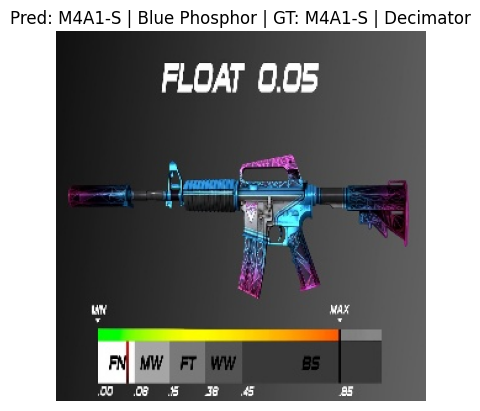

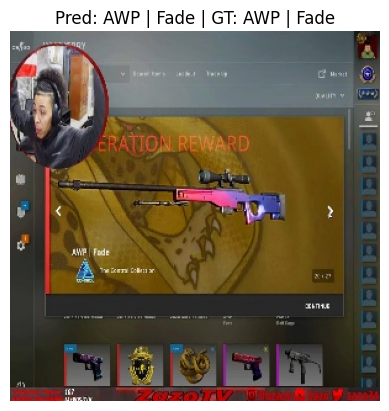

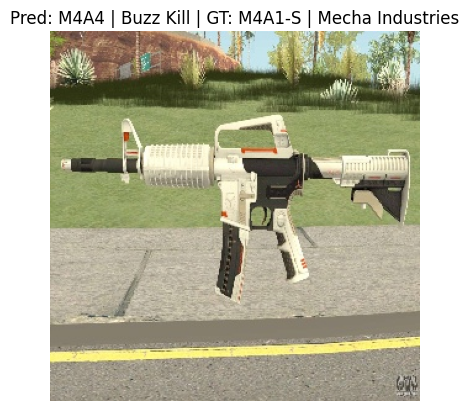

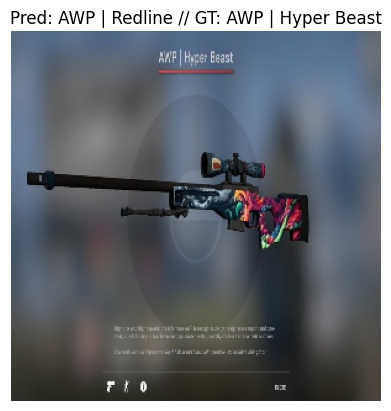

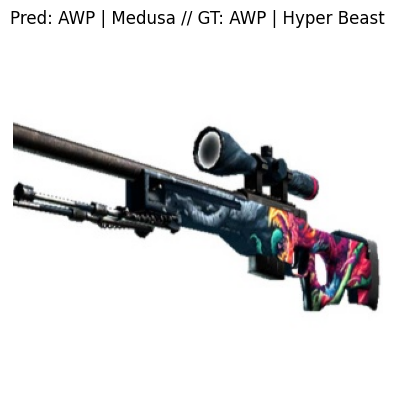

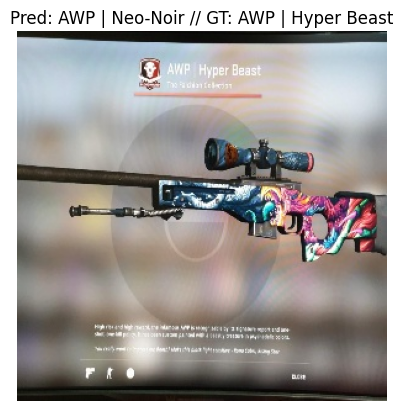

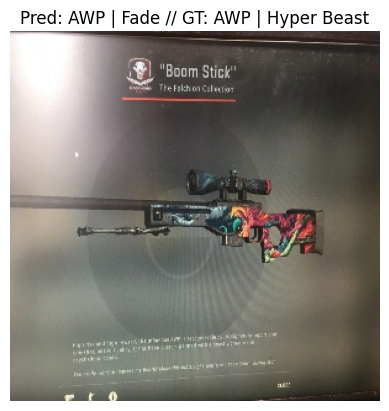

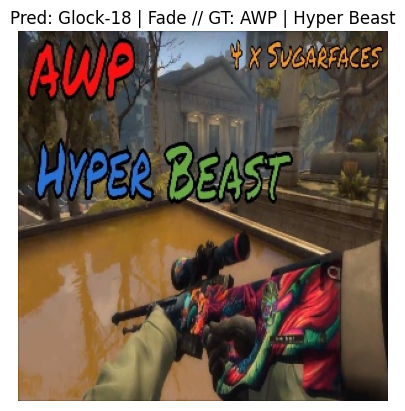

In [13]:
# Vemos el accuracy al clasificar solo el arma (sin la skin)
pred_labels = [num2label[l] for l in pred_labels_num]
pred_weapons = [label.split("|")[0].strip() for label in pred_labels]
test_weapons = [label.split("|")[0].strip() for label in test_labels]
acc2 = np.sum(np.array(pred_weapons) == np.array(test_weapons)) / len(test_weapons)
print(f"Accuracy (solo arma, no skin): {acc2}")


# Mostramos algunas predicciones
for img_id in random.sample(range(len(test_images)), 3):
    img_path = os.path.join(dataset_dir, test_images[img_id])
    show_img(img_path, f"Pred: {num2label[pred_labels_num[img_id]]} | GT: {test_labels[img_id]}")

count = 0
# El awp hyper beast no tuvo ningún acierto, veamos algunas las predicciones para este skin
for img_id in range(len(test_images)):
    if count == 5:
        break
    if test_labels[img_id] == "AWP | Hyper Beast":
        count += 1
        img_path = os.path.join(dataset_dir, test_images[img_id])
        show_img(img_path, f"Pred: {num2label[pred_labels_num[img_id]]} // GT: {test_labels[img_id]}")

## Transfer Learning
Ahora en vez de usar el modelo solo para extraer descriptores, entrenaremos la capa fully-connected con nuestro dataset. Luego usaremos el modelo resultante para clasificar las imágenes.

In [14]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

SEED = 1
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Debemos convertir nuestro dataset a uno de torch
class CSGOSkinsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(root_dir), key=lambda x: int(x.split(".")[0])) 
        self.labels = [label2num[l] for l in LABELS]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

csgo_dataset = CSGOSkinsDataset(dataset_dir, transform=preprocess)

In [15]:
# Separamos el dataset en train y test
train_size = int(0.8 * len(csgo_dataset))
test_size = len(csgo_dataset) - train_size
train_dataset, test_dataset = random_split(csgo_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [16]:
# Seguimos usando ResNet
model = resnet50(pretrained=True)
model.to(device)

# La capa fully connected clasificará nuestras 58 skins
model.fc = nn.Linear(model.fc.in_features, 58)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Entrenamiento
epochs = 10
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward y optimizacion
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    losses.append(epoch_loss)
    print(f"Época: {epoch+1}, Loss: {epoch_loss:.4f}")




/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Época: 1, Loss: 3.7605
Época: 2, Loss: 2.2461
Época: 3, Loss: 1.0662
Época: 4, Loss: 0.5224
Época: 5, Loss: 0.2749
Época: 6, Loss: 0.1576
Época: 7, Loss: 0.0990
Época: 8, Loss: 0.0728
Época: 9, Loss: 0.0556
Época: 10, Loss: 0.0447


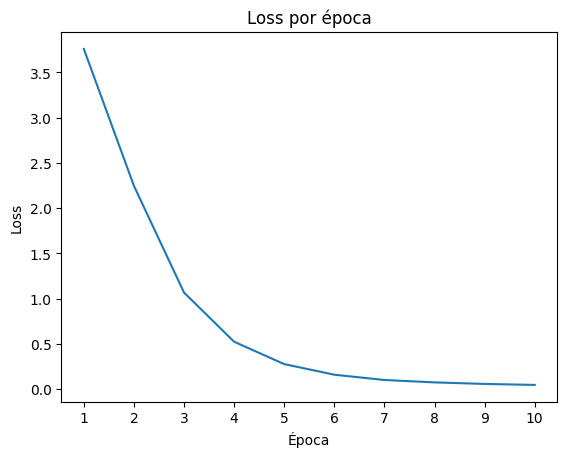

In [17]:
# Revisamos el loss
plt.plot([i+1 for i in range(epochs)], losses)
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.xticks([i+1 for i in range(epochs)])
plt.show()

In [18]:
# Evaluamos el modelo en el conjunto de test
model.eval()
correct = 0
total = 0
predicted_labels = []
real_labels = [] 
filenames = [] 

with torch.no_grad():
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        inputs = img.unsqueeze(0).to(device)
        labels = torch.tensor([label]).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.append(predicted.item())
        real_labels.append(labels.item())

        # Guardamos el nombre de la imagen para mostrarla después
        file_id = test_dataset.indices[i]
        filenames.append(file_id)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9480


2062


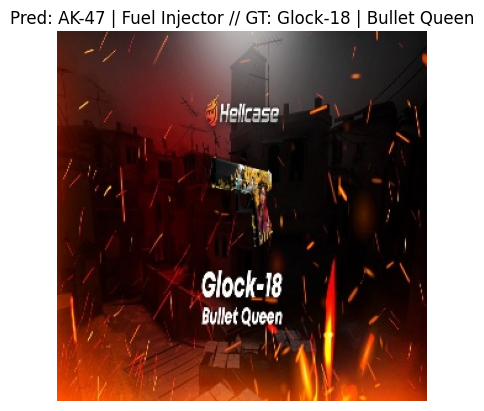

638


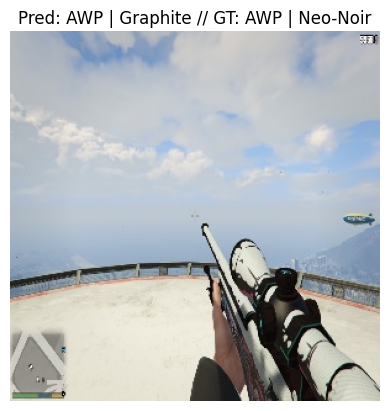

969


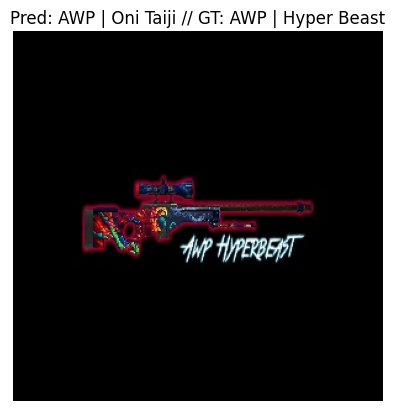

1846


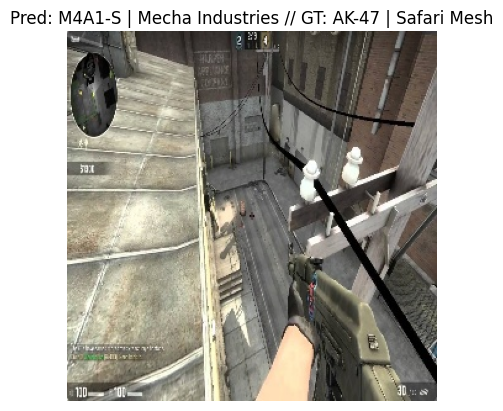

300


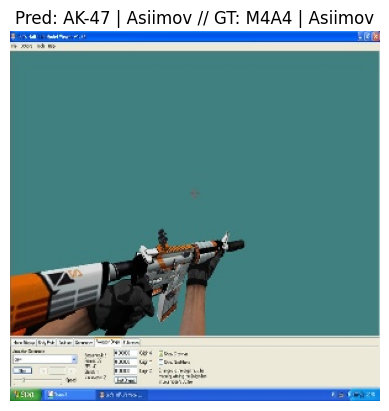

1988


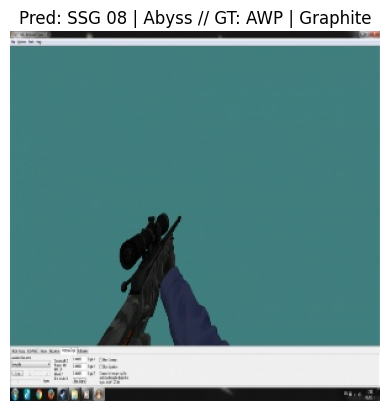

309


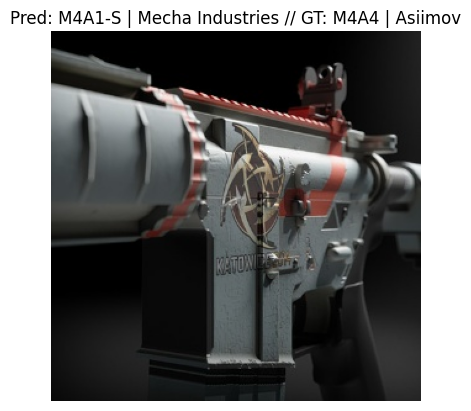

849


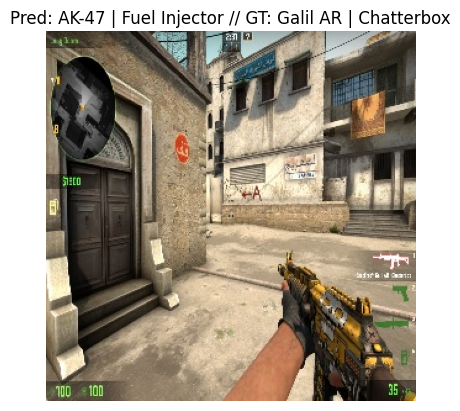

In [19]:
# visualizamos algunas predicciones incorrectas
wrongs = 0
for file_id, predicted_label, real_label in (list(zip(filenames, predicted_labels, real_labels))):
    if predicted_label == real_label:
        continue
    if wrongs == 8:
        break
    wrongs += 1
    img_path = os.path.join(dataset_dir, f"{file_id}.jpg")
    print(file_id)
    title = f"Pred: {num2label[predicted_label]} // GT: {num2label[real_label]}"
    show_img(img_path, title)

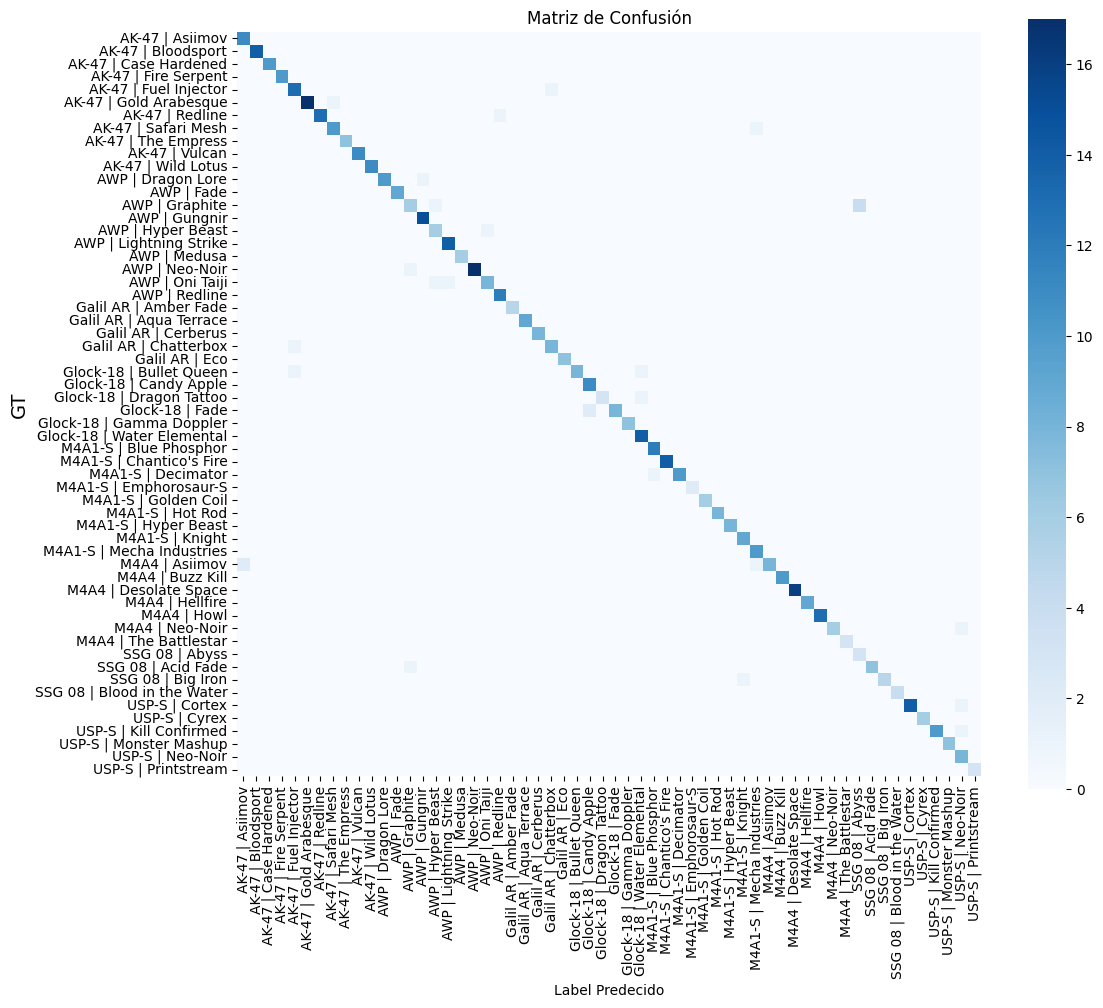

In [20]:
# Matriz de confusion
predicted_categories = [num2label[l] for l in predicted_labels]
real_categories = [num2label[l] for l in real_labels]

sorted_categories = sorted(unique_labels)
plot_confusion_matrix(real_categories, predicted_categories, sorted_categories)

presición, recall, F1-score:

In [21]:
print(classification_report(real_categories, predicted_categories, target_names=sorted_categories))

                             precision    recall  f1-score   support

            AK-47 | Asiimov       0.85      1.00      0.92        11
         AK-47 | Bloodsport       1.00      1.00      1.00        14
      AK-47 | Case Hardened       1.00      1.00      1.00        10
       AK-47 | Fire Serpent       1.00      1.00      1.00        10
      AK-47 | Fuel Injector       0.87      0.93      0.90        14
     AK-47 | Gold Arabesque       1.00      0.94      0.97        18
            AK-47 | Redline       1.00      0.93      0.96        14
        AK-47 | Safari Mesh       0.91      0.91      0.91        11
        AK-47 | The Empress       1.00      1.00      1.00         7
             AK-47 | Vulcan       1.00      1.00      1.00        11
         AK-47 | Wild Lotus       1.00      1.00      1.00        11
          AWP | Dragon Lore       1.00      0.91      0.95        11
                 AWP | Fade       1.00      1.00      1.00         9
             AWP | Graphite      

Se observa que el modelo entrenado tiene un rendimiento mucho mejor que el clasificador con K-NN. Aquí se logra un accuracy de 94.27% en el dataset de test.

In [22]:
import requests
# Podemos descargar una imagen de internet y predecir su label
def predict_image_label(img_url: str):
    # Descargamos la imagen
    try:
        img_data = requests.get(img_url).content
    except:
        print("Error when downloading image")
        return
    img_path = os.path.join(os.getcwd(), "test.jpg")
    with open(img_path, "wb") as f:
        f.write(img_data)

    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0).to(device)
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
    prediction = num2label[predicted.item()]
    # Visualizamos la imagen
    show_img(img_path, "Pred: "+prediction)
    return prediction




Probamos el modelo con algunas imágenes sacadas de internet. Observamos que confundió el "AWP | Asiimov" con el "AK-47 | Asiimov", dos armas distintas pero que tienen la misma skin. Además, se equivoca con imágenes de partidas profesionales, esto se puede deber a que en las transmisiones de partidas profesionales se usan HUDs (Heads Up Display) que agregan información no deseada, como la cámara de los jugadores, el marcador, las estadísticas de cada jugador, etc. Cabe destacar que el dataset no contiene capturas de partidas profesionales. Por otro lado, las imágenes "fáciles" de clasificar, correspondientes a fotos de la skin sola o dentro del juego pero sin elementos extras, el modelo clasifica de buena forma.

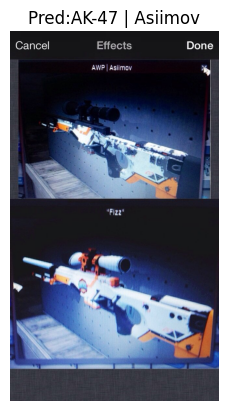

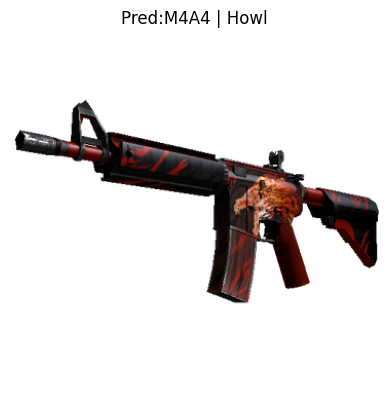

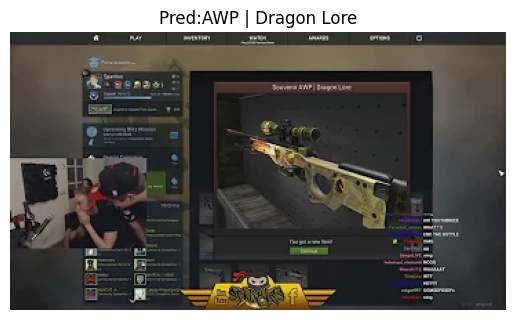

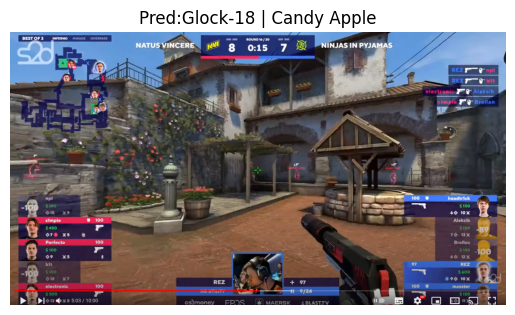

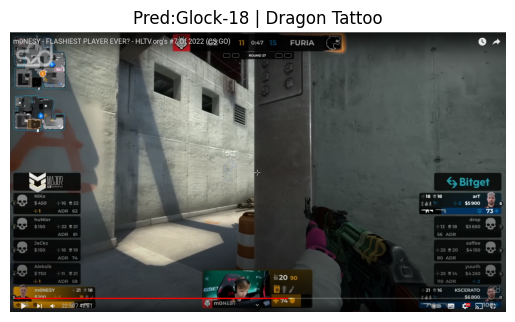

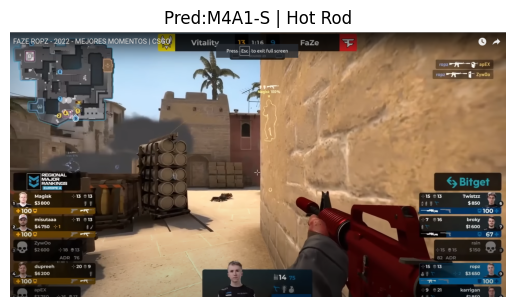

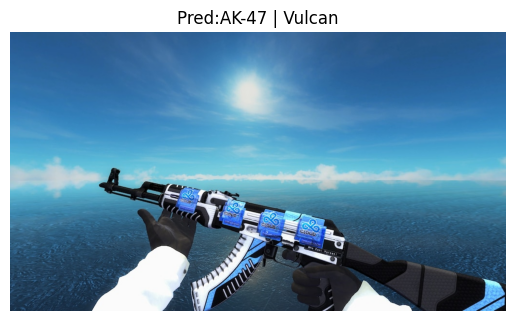

'AK-47 | Vulcan'

In [23]:
# Imagen de mala calidad -> Da incorrecto
awp_asiimov = "https://external-preview.redd.it/GcjXL9cE0PZDFeJA47xGSmypr89FBwavw37zhKruhk0.jpg?auto=webp&s=0424d0435fbb8700c0f7553887b671e8b9461a3e"
predict_image_label(awp_asiimov)

# # Imagen "fácil", solo contiene el arma. -> Correcto
m4a4_howl = "https://community.akamai.steamstatic.com/economy/image/-9a81dlWLwJ2UUGcVs_nsVtzdOEdtWwKGZZLQHTxDZ7I56KU0Zwwo4NUX4oFJZEHLbXH5ApeO4YmlhxYQknCRvCo04DEVlxkKgpou-6kejhjxszFJTwT09S5g4yCmfDLP7LWnn9u5MRjjeyP9tqhiQ2yqEo6Mmn3doPBcwZqZQrRr1O-we_sgMO5tZ_BzCFr6ycltmGdwULa1vGJFg/360fx360f"
predict_image_label(m4a4_howl)

# # thumbnail de youtube -> Correcto
awp_dragon_lore = "https://i.ytimg.com/vi/CEzFs2xDd9s/hq720.jpg?sqp=-oaymwEcCOgCEMoBSFXyq4qpAw4IARUAAIhCGAFwAcABBg==&rs=AOn4CLAjXqMWd5TC9lSWcOE4Q0mAUzGwgw"
predict_image_label(awp_dragon_lore)

# # screenshot de una partida profesional -> Incorrecto
usp_cyrex = "https://i.imgur.com/43ZuSDa.png"
predict_image_label(usp_cyrex)

# # otra partida profesional -> Incorrecto
ak47_fire_serpent = "https://i.imgur.com/odi26vA.png"
predict_image_label(ak47_fire_serpent)

# # ...otra partida profesional -> Correcto!



m4a1s_hot_rod = "https://i.imgur.com/s3mYNbe.png"
predict_image_label(m4a1s_hot_rod)


# ak vulcan con stickers
predict_image_label("https://steamuserimages-a.akamaihd.net/ugc/320122457680991639/526C07D87B0F90F771EF7EFC5857EA41B6B71284/?imw=1024&imh=576&ima=fit&impolicy=Letterbox&imcolor=%23000000&letterbox=true")
